In [ ]:
import torch
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, depth, output_dim):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        # output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

In [2]:
import sys
sys.path.append('../utils/')

In [9]:
from biasvariance_toolkit import estimate_bias_variance_0_1

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim

In [12]:
import torchvision
from torchvision import datasets,transforms

In [13]:
def get_cifar10_data(num_samples=None, train=True):
    """Loads and preprocesses the CIFAR-10 dataset for the experiment."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),  # mean per channel
                             (0.5, 0.5, 0.5))  # std per channel
    ])

    dataset = torchvision.datasets.CIFAR10(root='./data', train=train,
                                           download=True, transform=transform)

    if num_samples is not None:
        indices = torch.randperm(len(dataset))[:num_samples]
        dataset = torch.utils.data.Subset(dataset, indices)
    return dataset

In [14]:
train_dataset = get_cifar10_data(num_samples=10000, train=True)
test_dataset  = get_cifar10_data(num_samples=3000, train=False)
def dataset_to_numpy(dataset):
    X_list, y_list = [], []
    for data, target in dataset:
        # data shape: (C,H,W), convert to numpy and flatten
        X_list.append(data.numpy().reshape(-1))
        y_list.append(target)
    X_np = np.stack(X_list, axis=0).astype(np.float32)  # shape: (N, 3072)
    y_np = np.array(y_list, dtype=np.int64)             # integer labels for CrossEntropyLoss
    return X_np, y_np

X_train_np, y_train_np = dataset_to_numpy(train_dataset)
X_test_np, y_test_np   = dataset_to_numpy(test_dataset)

print(X_train_np.shape, y_train_np.shape)  # (10000, 3072), (10000,)
print(X_test_np.shape, y_test_np.shape)  

Files already downloaded and verified
Files already downloaded and verified
(10000, 3072) (10000,)
(3000, 3072) (3000,)


In [15]:
X_train_np.shape,X_test_np.shape

((10000, 3072), (3000, 3072))

In [16]:
y_train_np.shape,y_test_np.shape

((10000,), (3000,))

In [17]:
NUM_BOOTSTRAP_MODELS = 30
MAX_EPOCHS = 500
PATIENCE = 500
LEARNING_RATE = 0.001

hidden_unit_sizes =[8,32,64,128,256,512,1024,20248]

In [18]:
results = []
for hidden_units in hidden_unit_sizes:
    print(f"---Training with {hidden_units} hidden units----")
    avg_bias, avg_var, avg_exp_loss, empirical_01_loss,avg_train_loss,_= estimate_bias_variance_0_1( model_class=MLPClassifier,
      X_train=X_train_np,
      y_train=y_train_np,
      X_test=X_test_np,
      y_test=y_test_np,
      loss_fn=nn.CrossEntropyLoss(),
      model_kwargs={'input_dim':32*32*3,'hidden_dim':hidden_units,'depth':1,'output_dim':10},
      num_models=NUM_BOOTSTRAP_MODELS,
      max_epochs=MAX_EPOCHS,
      patience=PATIENCE,
      lr=LEARNING_RATE,
      batch_size=128)
    results.append({
        'hidden_units': hidden_units,
        'bias': avg_bias,
        'variance': avg_var,
        'avg_exp_loss': avg_exp_loss,
        'empirical_01_loss': empirical_01_loss,
        'avg_train_loss':avg_train_loss
    })

---Training with 8 hidden units----

--- Training Model 1/30 ---


KeyboardInterrupt: 

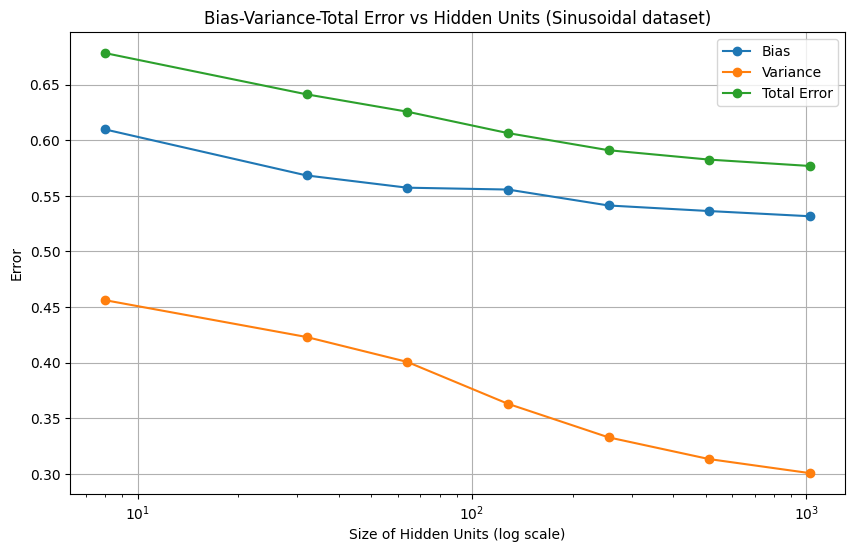

In [12]:
hidden_unit_sizes =[8,32,64,128,256,512,1024]
bias = [r['bias'] for r in results]
variance = [r['variance'] for r in results]
total_error = [r['avg_exp_loss'] for r in results]
avg_train_loss = [np.mean(r['avg_train_loss'],axis=0) for r in results]

# --- Plot 1: Bias, Variance, Total Error ---
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_sizes, bias, marker='o', label='Bias')
plt.plot(hidden_unit_sizes, variance, marker='o', label='Variance')
plt.plot(hidden_unit_sizes, total_error, marker='o', label='Total Error')
plt.xscale('log')  # Log scale for hidden units
plt.xlabel('Size of Hidden Units (log scale)')
plt.ylabel('Error')
plt.title('Bias-Variance-Total Error vs Hidden Units (CIFAR-10 dataset)')
plt.legend()
plt.grid(True)
plt.show()

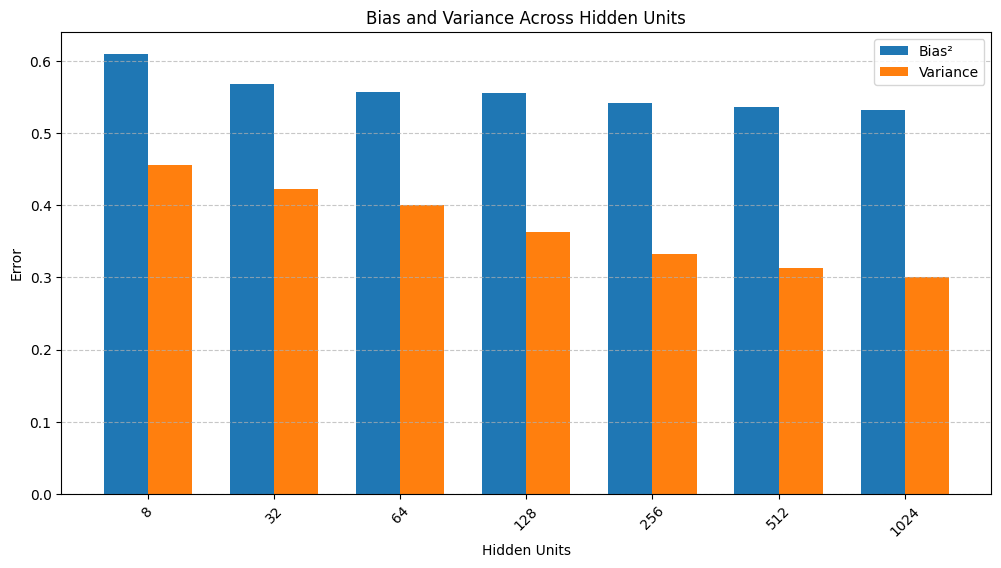

In [13]:
bias = [r['bias'] for r in results]
variance = [r['variance'] for r in results]


x = np.arange(len(hidden_unit_sizes))  
width = 0.35  
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, bias, width, label='Bias')
plt.bar(x + width/2, variance, width, label='Variance')


plt.xticks(x, hidden_unit_sizes, rotation=45)
plt.xlabel('Hidden Units')
plt.ylabel('Error')
plt.title('Bias and Variance Across Hidden Units')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

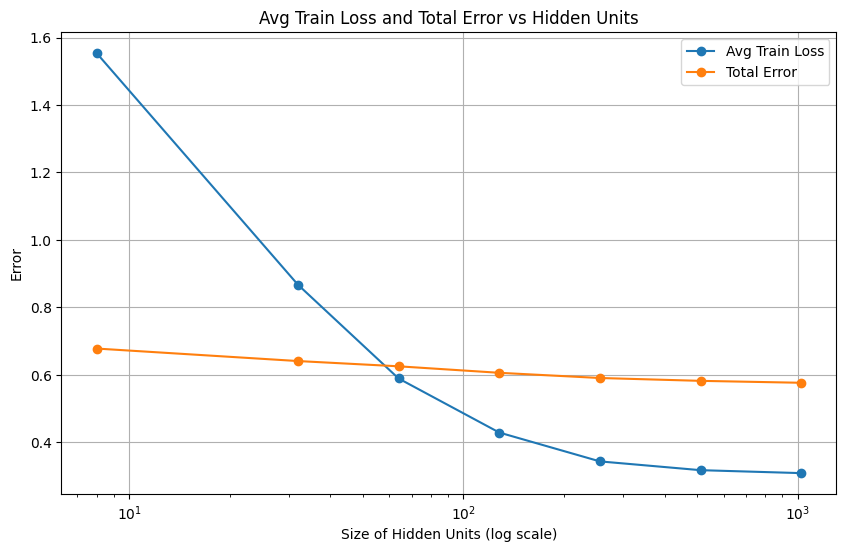

In [14]:
plt.figure(figsize=(10, 6))
train_loss = mean_loss = np.mean(avg_train_loss, axis=0)
plt.plot(hidden_unit_sizes, avg_train_loss, marker='o', label='Avg Train Loss')
plt.plot(hidden_unit_sizes, total_error, marker='o', label='Total Error')
plt.xscale('log')  # Log scale for hidden units
plt.xlabel('Size of Hidden Units (log scale)')
plt.ylabel('Error')
plt.title('Avg Train Loss and Total Error vs Hidden Units')
plt.legend()
plt.grid(True)
plt.show()

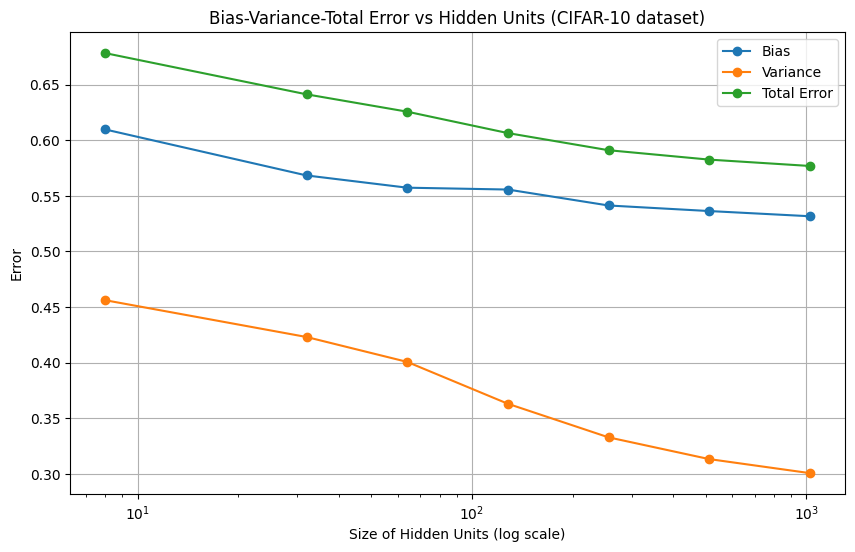

In [15]:
hidden_unit_sizes =[8,32,64,128,256,512,1024]
bias = [r['bias'] for r in results]
variance = [r['variance'] for r in results]
total_error = [r['avg_exp_loss'] for r in results]
avg_train_loss = [np.mean(r['avg_train_loss'],axis=0) for r in results]

# --- Plot 1: Bias, Variance, Total Error ---
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_sizes, bias, marker='o', label='Bias')
plt.plot(hidden_unit_sizes, variance, marker='o', label='Variance')
plt.plot(hidden_unit_sizes, total_error, marker='o', label='Total Error')
plt.xscale('log')  # Log scale for hidden units
plt.xlabel('Size of Hidden Units (log scale)')
plt.ylabel('Error')
plt.title('Bias-Variance-Total Error vs Hidden Units (CIFAR-10 dataset)')
plt.legend()
plt.grid(True)
plt.show()

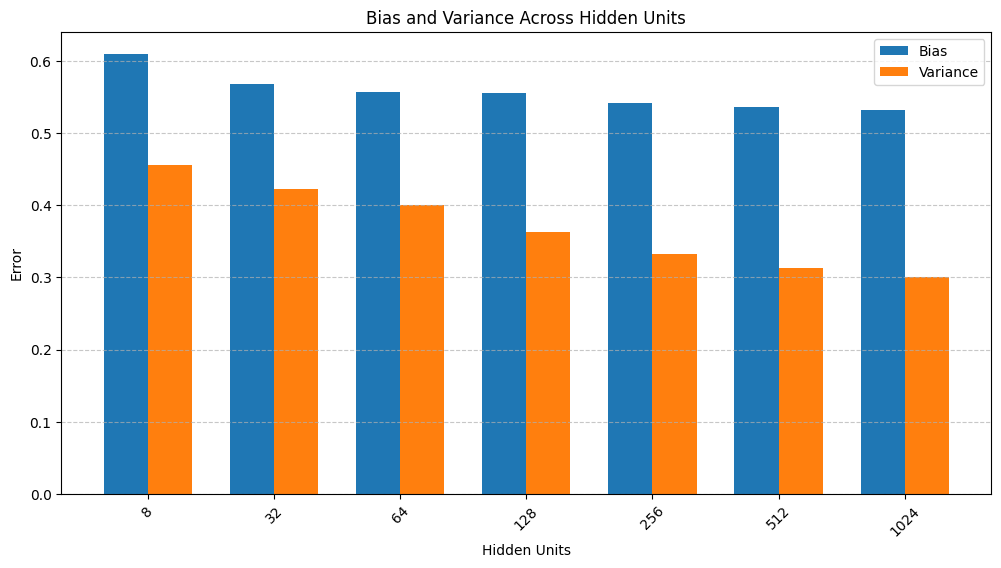

In [16]:
bias = [r['bias'] for r in results]
variance = [r['variance'] for r in results]


x = np.arange(len(hidden_unit_sizes))  
width = 0.35  
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, bias, width, label='Bias')
plt.bar(x + width/2, variance, width, label='Variance')


plt.xticks(x, hidden_unit_sizes, rotation=45)
plt.xlabel('Hidden Units')
plt.ylabel('Error')
plt.title('Bias and Variance Across Hidden Units')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()